### DS7337 NLP - HW 8
#### David Wei

# **Homework 8**

Perform a vocabulary-based sentiment analysis of the movie reviews you used in homework 5 and homework 7, by doing the following:
1.	In Python, load one of the sentiment vocabularies referenced in the textbook, and run the sentiment analyzer as explained in the corresponding reference. Add words to the sentiment vocabulary, if you think you need to, to better fit your particular text collection.
2.	For each of the clusters you created in homework 7, compute the average, median, high, and low sentiment scores for each cluster. Explain whether you think this reveals anything interesting about the clusters.
3.	For extra credit, analyze sentiment of chunks as follows:
a.	Take the chunks from homework 5, and in Python, run each chunk individually through your sentiment analyzer that you used in question 1. If the chunk registers a nonneutral sentiment, save it in a tabular format (the chunk, the sentiment score).
b.	Now sort the table twice, once to show the highest negative-sentiment-scoring chunks at the top and again to show the highest positive-sentiment-scoring chunks at the top. Examine the upper portions of both sorted lists, to identify any trends, and explain what you see. 

In [1]:
# python
import os
import numpy as np
import re
import pandas as pd
import string
import warnings
warnings.filterwarnings("ignore")
# viz & GUI
from IPython.display import Image
from IPython.core.display import HTML 
import matplotlib.pyplot as plt
import seaborn as sns
# sklearn
from sklearn.preprocessing import minmax_scale
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
# NLTK
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import ToktokTokenizer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer as sia
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import stopwords

## **Pre-Processing**
#### Loading in IMDB Movie Review Data via .pkl (Pickle) File
For how the pickled data was extracted, please refer to this the scraper code on [GitHub](https://github.com/chee154/NLP_study-py/blob/main/HW5_IMDB-Review-Scraper/DS7337%20NLP%20-%20HW%205%20-%20David%20Wei.ipynb). 

In [2]:
df = pd.read_pickle("HW5_IMDB_User_Review.pkl")
# remove the review_link
df = df[df.columns[~df.columns.isin(['movie_user_review_link'])]]
# print data
df.head(5)

,movie_title,movie_user_review_rating,movie_user_review_txt
0,Ad Astra,8,Let me start off by saying that the movie's pa...
1,Alien,10,"Alien is the pinnacle of sci-fi horror, and it..."
2,Star Wars: Episode IV - A New Hope,10,I can never pick a favorite movie because diff...
3,12 Monkeys,9,Twelve Monkeys is a science fiction movie dire...
4,Dark City,9,simply wonderful on every level. A matrix meet...


#### Extracting relevant data

In [3]:
# Function to preprocess Reviews data
def clean_data(data,name):
    '''
    Runs pre-processing steps on data to clean text and make ready for analysis
    Source: https://www.kaggle.com/yommnamohamed/sentiment-analysis-using-sentiwordnet
    '''
    if name == None:
        # Proprocessing the data
        data=data.str.lower()
        # Code to remove the Hashtags from the text
        data=data.apply(lambda x:re.sub(r'\B#\S+','',x))
        # Code to remove the links from the text
        data=data.apply(lambda x:re.sub(r"http\S+", "", x))
        # Code to remove the Special characters from the text 
        data=data.apply(lambda x:' '.join(re.findall(r'\w+', x)))
        # Code to substitute the multiple spaces with single spaces
        data=data.apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))
        # Remove the twitter handlers
        data=data.apply(lambda x:re.sub('@[^\s]+','',x))
        # Code to remove all the single characters in the text
        # data=data.apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))
        return data
        
    if name != None:
        # Proprocessing the data
        data[name]=data[name].str.lower()
        # Code to remove the Hashtags from the text
        data[name]=data[name].apply(lambda x:re.sub(r'\B#\S+','',x))
        # Code to remove the links from the text
        data[name]=data[name].apply(lambda x:re.sub(r"http\S+", "", x))
        # Code to remove the Special characters from the text 
        data[name]=data[name].apply(lambda x:' '.join(re.findall(r'\w+', x)))
        # Code to substitute the multiple spaces with single spaces
        data[name]=data[name].apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))
        # Remove the twitter handlers
        data[name]=data[name].apply(lambda x:re.sub('@[^\s]+','',x))
        # Code to remove all the single characters in the text
        # data[name]=data[name].apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))
        return data

def tokenize_text(text):
    toktok = ToktokTokenizer()
    text_tokenized = toktok.tokenize(text)
    return text_tokenized

def remove_stopwords(cleaned_data):
    # remove stopwords
    stop_words = set(stopwords.words('english')) 
    filtered_sentence = [w for w in tokenize_text(cleaned_data) if not w in stop_words]
    return filtered_sentence

def make_sentence(word_tokens):
    sentence = ' '.join(word for word in word_tokens)
    return sentence


def preprocessed_data(df):
    '''
    feed in dataframe of cleaned text, return list of preprocessed sentences
    '''
    preprocessed_reviews = []
    for i in df:
        # tokensize and remove stopwords
        filtered = remove_stopwords(i)
        # convert back to sentence
        sentence = make_sentence(filtered)
        # store preprocessed data
        preprocessed_reviews.append(sentence)
    return preprocessed_reviews


In [4]:
# get only the review from the dataframe
df_reviews = df['movie_user_review_txt']
# get the movie title
movie_titles = list(df['movie_title'])
# gets all the review ratings
user_review_ratings = df['movie_user_review_rating']

# apply cleaning to data
# df = clean_data(df, 'movie_user_review_txt')
df_reviews = clean_data(df_reviews, None)

# apply pre-processsing to data
cleaned_df_reviews = preprocessed_data(df_reviews)

# append preprocessed reviews back to df
df['cleaned_reviews'] = cleaned_df_reviews

# **1. Reviewing Movie Review Sentiment**

To evaluate the sentiment of the review, we will be using the **VADER** sentiment library provided by NLTK. VADER (Valence Aware Dictionary and sEntiment Reasoner) consists of a rule-based model of evaluating corpus sentiment and thus does not require any training data. Using VADER, we will use the "Compound" value which provides a single measure of the overall sentiment (-1 to 1 scale) and then standardize the sentiment into categories of "positive", "neutral", and "negative". 

To understand the Compound score, the higher the value is to 1, the higher the overall positivity of the text is. Using this information, we then wanted to see if ther was any correlation between the review ratings and the overall sentiment. The hypothesis here is that highly rated movies should also have a high sentiment, expressing possitivity towards the movie. However, it was found that there was actually very little correlation (corr = 0.097). Plotting the correlation showed that at each rating level of the movie, there was roughly an equal distribution of both negative and positive sentiment regardless of what the movie rating was. 

The code below is following the overall design of the following:
https://www.kaggle.com/yommnamohamed/sentiment-analysis-using-sentiwordnet

#### Aggregating the Sentiment for each Review

In [5]:
# init SentimentAnalyer
sid=sia()

neg_val =  []
neu_val =  []
pos_val =  []
comp_val = []
overall_sentiment = []

for i in df['cleaned_reviews']:
    compound_score = sid.polarity_scores(i)['compound']
    comp_val.append(compound_score)    

    # standardising sentiment scores
    if compound_score >= 0.05:
        overall_sentiment.append('positive')
    elif compound_score > -0.05 and compound_score < 0.05:
        overall_sentiment.append('neutral')
    elif compound_score <= -0.05:
        overall_sentiment.append('negative')

In [6]:
# append sentiment scores and values back to dataframe
df['sentiment_score'] = comp_val
df['overall_sentiment'] = overall_sentiment
df['movie_user_review_rating'] = df['movie_user_review_rating'].astype(str).astype(int)
df.head(6)

,movie_title,movie_user_review_rating,movie_user_review_txt,cleaned_reviews,sentiment_score,overall_sentiment
0,Ad Astra,8,Let me start off by saying that the movie's pa...,let start saying movie pacing unusual think pa...,0.8402,positive
1,Alien,10,"Alien is the pinnacle of sci-fi horror, and it...",alien pinnacle sci fi horror standard measured,-0.5719,negative
2,Star Wars: Episode IV - A New Hope,10,I can never pick a favorite movie because diff...,never pick favorite movie different movies dif...,0.6283,positive
3,12 Monkeys,9,Twelve Monkeys is a science fiction movie dire...,twelve monkeys science fiction movie directed ...,-0.6808,negative
4,Dark City,9,simply wonderful on every level. A matrix meet...,simply wonderful every level matrix meets trum...,0.9477,positive
5,Mad Max: Fury Road,5,Mad Max: Fury Road did not appeal to me in the...,mad max fury road appeal slightest chose watch...,-0.0258,neutral


In [7]:
df['movie_user_review_rating'].corr(df['sentiment_score'])

0.0970062201209299

<AxesSubplot:xlabel='movie_user_review_rating', ylabel='sentiment_score'>

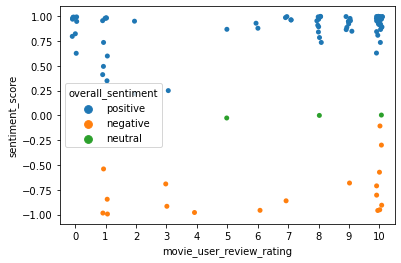

In [8]:
sns.stripplot(x="movie_user_review_rating", y="sentiment_score", hue="overall_sentiment", data=df)

# **2. Reviewing Cluster Sentiment Scores**

By looking at the summary values of our Cluster's sentiment scores, we can see that though the **MIN** and **MAX** polarity (sentiment) scores do not change much within each cluster, we can see that the Cluster 2 has the highest "overall" positive sentiment whereas Cluster 3 has the lowerest overall sentiment. In other words, Cluster 2 is the most positive while Cluster 3 is the least positive. 

|   cluster_num |     mean |   median |    max |     min |
|--------------:|---------:|---------:|-------:|--------:|
|             0 | 0.612819 |  0.9671  | 0.9976 | -0.993  |
|             1 | 0.532973 |  0.8771  | 0.9981 | -0.9501 |
|             2 | 0.9887   |  0.9887  | 0.9887 |  0.9887 |
|             3 | 0.530204 |  0.95365 | 0.9956 | -0.9834 |

#### Vectorizing the Reviews Text

In [9]:
# init vectorizer
vectorizer = TfidfVectorizer(strip_accents='ascii', lowercase=True)

# vectorize
tf_idf = vectorizer.fit_transform(df['cleaned_reviews'])
print(tf_idf.shape)
print(type(tf_idf))

(100, 5077)
<class 'scipy.sparse.csr.csr_matrix'>


In [10]:
def view_matrix(matrix, index_df):
    # convert document-term matrix to array 
    tfidf_array = matrix.toarray()
    # tokenize vectors to get the actual term (movie title) names
    tokens = vectorizer.get_feature_names()

    #### Converts tokens to DF ####
    # doc_names = [f'book_{i+1}' for i, _ in enumerate(matrix)]
    doc_names = [index_df[i] for i, _ in enumerate(tfidf_array)]
    df = pd.DataFrame(data=tfidf_array, index=doc_names, columns=tokens)
    return df,tokens

### gets tokens
tfidf_tokens = view_matrix(tf_idf, movie_titles)[1]

##### creates tf-idf matrix df
tfidf_df = view_matrix(tf_idf, movie_titles)[0]
tfidf_df.reset_index(drop=True, inplace=True)

##### creates tf-idf matrix df with 'movie_user_review_rating'
tfdf_review_df = pd.concat([tfidf_df, user_review_ratings],axis=1)
# tfdf_review_df.head(5)
tfidf_df.head(5)


,000,06,10,108,11,12,13,15,1500,16,...,younger,yubb,zap,zaps,zed,zero,zimmer,zone,zoom,zooms
0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.11138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Reducing Sparse TF-IDF Matrix Dimensionality with LSA

In [11]:
from sklearn.decomposition import TruncatedSVD
from scipy import sparse as sp

# init SVD LSA
svd_clf = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
# store reduced dimension arrays
X_lsa = svd_clf.fit_transform(tfidf_df)
X_review_lsa = svd_clf.fit_transform(tfdf_review_df)
print(X_lsa.shape)

(100, 2)


#### Centroid Based Clustering with KMeans (K=4)

In [12]:
def kmeans_model(k, data):
    optimal_k = k
    kmeans = KMeans(n_clusters=optimal_k, init='k-means++',random_state=42,n_init=10, max_iter=250)
    kmeans.fit(data)

    kmeans_labels = kmeans.labels_
    print(f'KMeans Silhouette Score (k={optimal_k}): {silhouette_score(data, kmeans_labels):.5f}')
    return kmeans_labels

model = kmeans_model(4, X_lsa)

KMeans Silhouette Score (k=4): 0.40201


#### Appending dataframe with Predicted Cluster Number

In [13]:
df['cluster_num'] = model.astype(str).astype(int)
df.head(6)

,movie_title,movie_user_review_rating,movie_user_review_txt,cleaned_reviews,sentiment_score,overall_sentiment,cluster_num
0,Ad Astra,8,Let me start off by saying that the movie's pa...,let start saying movie pacing unusual think pa...,0.8402,positive,3
1,Alien,10,"Alien is the pinnacle of sci-fi horror, and it...",alien pinnacle sci fi horror standard measured,-0.5719,negative,1
2,Star Wars: Episode IV - A New Hope,10,I can never pick a favorite movie because diff...,never pick favorite movie different movies dif...,0.6283,positive,0
3,12 Monkeys,9,Twelve Monkeys is a science fiction movie dire...,twelve monkeys science fiction movie directed ...,-0.6808,negative,3
4,Dark City,9,simply wonderful on every level. A matrix meet...,simply wonderful every level matrix meets trum...,0.9477,positive,1
5,Mad Max: Fury Road,5,Mad Max: Fury Road did not appeal to me in the...,mad max fury road appeal slightest chose watch...,-0.0258,neutral,1


#### Group by Each Cluster and find {average, median, max, min} sentiment scores for each cluster

In [183]:
aggregate_summary = df.groupby(['cluster_num']).sentiment_score.agg(['mean', 'median', 'max', 'min'])
print(aggregate_summary.to_markdown())

|   cluster_num |     mean |   median |    max |     min |
|--------------:|---------:|---------:|-------:|--------:|
|             0 | 0.612819 |  0.9671  | 0.9976 | -0.993  |
|             1 | 0.532973 |  0.8771  | 0.9981 | -0.9501 |
|             2 | 0.9887   |  0.9887  | 0.9887 |  0.9887 |
|             3 | 0.530204 |  0.95365 | 0.9956 | -0.9834 |


In [15]:
# saving dataframe to pickle to prevent running everything again
df.to_pickle('HW8_IMDB_User_Review_sentiment.pkl')

# **3. Reviewing Cluster Sentiment Scores**

Using a different Sentiment library, **SentiWordNet**, this alternative method uses the position of the word in it's contextual sense which then uses WordNet to provide the sentiment to each synset (groupings of synonymous words that express the same concept). What's really good about SentiWordNet is that since it's using Wordnet synsets, it'll provide phrase level sentiment as opposed to word level (VADER) level sentiment. For purposes of this study, we will use only the top WordNet synset for each POS labeled below:

* Noun = n
* Verb = v
* Adjective = a
* Adverb = r

After aggregating the non-neutral (sentiment != 0) sentiment values per each review's sentence structure, we then review the top 10 and bottom 10 POS chunks. We can see that in the top 10 most positive chunks, there is a very clear understanding of why it's positive since 'kudos', 'priase' and 'excellent' are all very positive terms. On the other end, by reviewing the bottom 10 chunks, the distinction is less clear and more ambigious though still somewhat sensible with words like 'creepy'. Overall we can see that the chunks with a very strong (perfect) sentiment are without a doubt "positive" words while the rest can be left up to interpretation.   

##### Top 10 Most Positive Chunks

|      | chunk               |   sentiment |
|-----:|:--------------------|------------:|
| 2061 | ('kudos', 'NNP')    |       1     |
|  546 | ('praise', 'NN')    |       1     |
|  674 | ('excellent', 'JJ') |       1     |
|  675 | ('aliens', 'VBZ')   |       1     |
|  238 | ('better', 'JJR')   |       0.875 |
| 3315 | ('decent', 'JJ')    |       0.875 |
|  232 | ('standing', 'VBG') |       0.875 |
|  372 | ('2001', 'CD')      |       0.875 |
|  371 | ('better', 'RBR')   |       0.875 |
| 2786 | ('suited', 'VBN')   |       0.875 |

##### Top 10 Most Negative Chunks
|      | chunk                   |   sentiment |
|-----:|:------------------------|------------:|
| 1465 | ('see', 'VB')           |      -0.875 |
| 3812 | ('confirms', 'VBZ')     |      -0.875 |
| 1870 | ('pinbacker', 'NN')     |      -0.875 |
| 1869 | ('aspect', 'JJ')        |      -0.875 |
| 1868 | ('creepy', 'JJ')        |      -0.875 |
|  582 | ('make', 'VB')          |      -0.875 |
| 3909 | ('untraditional', 'JJ') |      -0.875 |
| 1150 | ('realised', 'VBD')     |      -0.875 |
| 2762 | ('cannot', 'VB')        |      -0.875 |
| 1811 | ('tend', 'JJ')          |      -0.875 |

In [177]:
df = pd.read_pickle("HW8_IMDB_User_Review_sentiment.pkl")

In [102]:
def penn_to_wn(tag):
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return None


def get_sentiment(word, tag):
    # wn_tag = penn_to_wn(tag)

    if tag not in (wn.NOUN, wn.ADJ, wn.ADV):
        return []
        
    synsets = wn.synsets(word, pos=tag)
    if not synsets:
        return []

    synset = synsets[0]
    synset_val = swn.senti_synset(synset.name())
    return [synset_val.pos_score(), synset_val.neg_score(), synset_val.obj_score()]

#### POS tagging reviews

In [103]:
# POS tag all sentences
postagged = []
for review in df['cleaned_reviews']:
    # first re-tokenize the cleaned (and pre-processed text)
    cleaned_tokenized = tokenize_text(review)
    # apply pos-tagging per review
    postagged.append(nltk.pos_tag(cleaned_tokenized))

# appending pos tagged back to dataframe
df['pos_tags'] = postagged

#### Applying Sentiment Analysis to POS Tags

In [142]:
sentiment_score = []
hw8_sentiment_score = []

for i in df['pos_tags']:
    review_sentiment_score = []

    for (x,y) in i:
        # gets tag
        wordnet_tag = penn_to_wn(y)
        # gets the sentiment
        sentiment_val = get_sentiment(x, wordnet_tag)

        for score in sentiment_val:
            try:
                pos_score = sentiment_val[0]
                neg_score = sentiment_val[1]
                # calcualtes the chunk score
                chunk_score = (pos_score-neg_score)
            except: 
                continue 
        # for every chunk in the review append all chunk scores
        review_sentiment_score.append(chunk_score)

    # return only non-neutral chunk scores
    review_sentiment_score_filtered = [val for val in review_sentiment_score if val != 0]

    # for every review get all non-neutral scores
    sentiment_score.append(review_sentiment_score_filtered)

    ####### THIS PORTION IS ONLY FOR HW 8 #######
    hw8_sentiment_score.append(review_sentiment_score)

#### Getting non-neutral chunk and it's sentiment

In [163]:
chunk_sentiment = []
for index, i in enumerate(hw8_sentiment_score):
    for chunk_index, val in enumerate(i):
        if val == 0:
            continue
        elif val != 0:
            # appending dictioanry of chunk and it's sentiments
            d = {'chunk': df["pos_tags"][index][chunk_index], 'sentiment': val}
            chunk_sentiment.append(d)

print(chunk_sentiment[0:5])   

[{'chunk': ('unusual', 'JJ'), 'sentiment': -0.5}, {'chunk': ('constant', 'JJ'), 'sentiment': 0.375}, {'chunk': ('strong', 'JJ'), 'sentiment': 0.5}, {'chunk': ('bad', 'JJ'), 'sentiment': -0.625}, {'chunk': ('whole', 'JJ'), 'sentiment': 0.125}]


In [178]:
chunk_sentiment_df = pd.DataFrame()
chunk_sentiment_df = chunk_sentiment_df.append(chunk_sentiment, ignore_index=True)

# remove duplicates
chunk_sentiment_df = chunk_sentiment_df.drop_duplicates(keep='first')

# top 10 highest chunks
top_10 = chunk_sentiment_df.sort_values(by=['sentiment'], ascending=False).head(10)
print(top_10.to_markdown())

# top 10 lowest chunks
bottom_10 = chunk_sentiment_df.sort_values(by=['sentiment'], ascending=True).head(10)
print(bottom_10.to_markdown())

|      | chunk               |   sentiment |
|-----:|:--------------------|------------:|
| 2061 | ('kudos', 'NNP')    |       1     |
|  546 | ('praise', 'NN')    |       1     |
|  674 | ('excellent', 'JJ') |       1     |
|  675 | ('aliens', 'VBZ')   |       1     |
|  238 | ('better', 'JJR')   |       0.875 |
| 3315 | ('decent', 'JJ')    |       0.875 |
|  232 | ('standing', 'VBG') |       0.875 |
|  372 | ('2001', 'CD')      |       0.875 |
|  371 | ('better', 'RBR')   |       0.875 |
| 2786 | ('suited', 'VBN')   |       0.875 |
|      | chunk                   |   sentiment |
|-----:|:------------------------|------------:|
| 1465 | ('see', 'VB')           |      -0.875 |
| 3812 | ('confirms', 'VBZ')     |      -0.875 |
| 1870 | ('pinbacker', 'NN')     |      -0.875 |
| 1869 | ('aspect', 'JJ')        |      -0.875 |
| 1868 | ('creepy', 'JJ')        |      -0.875 |
|  582 | ('make', 'VB')          |      -0.875 |
| 3909 | ('untraditional', 'JJ') |      -0.875 |
| 1150 | ('realised

# **For Future Work**
#### Averaging the sentiment per chunks (non-neutral) for overall review sentiment

In [180]:
overall_sentiment_score = []

for chunk in sentiment_score:
    if len(chunk) == 0:
        average_score = 0
    elif len(chunk) > 0:
        average_score = (sum(chunk) / len(chunk))

    overall_sentiment_score.append(average_score)

In [181]:
df['avg_sentiwordnet_sentiment'] = overall_sentiment_score
df.head(5)

,movie_title,movie_user_review_rating,movie_user_review_txt,cleaned_reviews,sentiment_score,overall_sentiment,cluster_num,avg_sentiwordnet_sentiment
0,Ad Astra,8,Let me start off by saying that the movie's pa...,let start saying movie pacing unusual think pa...,0.8402,positive,3,-0.014706
1,Alien,10,"Alien is the pinnacle of sci-fi horror, and it...",alien pinnacle sci fi horror standard measured,-0.5719,negative,1,-0.250000
2,Star Wars: Episode IV - A New Hope,10,I can never pick a favorite movie because diff...,never pick favorite movie different movies dif...,0.6283,positive,0,0.057292
3,12 Monkeys,9,Twelve Monkeys is a science fiction movie dire...,twelve monkeys science fiction movie directed ...,-0.6808,negative,3,-0.125000
4,Dark City,9,simply wonderful on every level. A matrix meet...,simply wonderful every level matrix meets trum...,0.9477,positive,1,0.209821


In [182]:
df['avg_sentiwordnet_sentiment'].corr(df['sentiment_score'])

0.39432636129459975